In [1]:
import torch
import numpy as np
import cv2
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

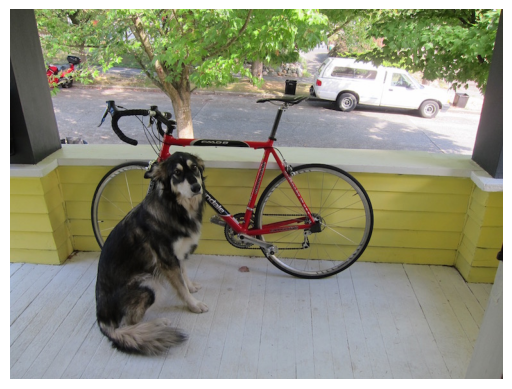

In [2]:
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    width, height = image.size
    return np.array(image), height, width

def show_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

image_path = 'images/dog.jpg'
image, h, w = load_image(image_path)
show_image(image)


In [3]:
def iou(bbox1, bbox2):
    x1 = max(bbox1[0], bbox2[0])
    y1 = max(bbox1[1], bbox2[1])
    x2 = min(bbox1[2], bbox2[2])
    y2 = min(bbox1[3], bbox2[3])
    
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area_bbox1 = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
    area_bbox2 = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])
    
    union = area_bbox1 + area_bbox2 - intersection
    return intersection / union if union > 0 else 0

In [4]:
def nms(boxes, scores, pc_threshold, iou_threshold):
    sorted_indices_desc = np.argsort(scores)[::-1]
    sorted_indices_desc = [idx for idx in sorted_indices_desc if scores[idx] >= pc_threshold]

    selected_indices = []

    while len(sorted_indices_desc) > 0:
        current = sorted_indices_desc[0]
        selected_indices.append(current)
        to_delete = []

        for i in range(1, len(sorted_indices_desc)):
            if iou(boxes[current], boxes[sorted_indices_desc[i]]) > iou_threshold:
                to_delete.append(i)
        to_delete.append(0)

        sorted_indices_desc = np.delete(sorted_indices_desc, to_delete)

    return selected_indices

In [5]:
def load_yolo_model(cfg_path, weights_path):
    net = cv2.dnn.readNet(weights_path, cfg_path)
    return net

In [6]:
def detect_objects(net, image):
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)

    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers().flatten()]

    np.set_printoptions(threshold=np.inf)
    detections = net.forward(output_layers)
    
    return detections

In [7]:
def apply_nms(detections, width, height, pc_threshold=0.5, iou_threshold=0.4):
    boxes = []
    confidences = []
    class_ids = []

    for output in detections:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = detection[4]
            if confidence > pc_threshold:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, x + w, y + h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indices = nms(boxes, confidences, pc_threshold, iou_threshold)
    return indices, boxes, confidences, class_ids

In [8]:
def draw_detections(image, indices, boxes, confidences, class_ids, class_names):
    for i in indices:
        box = boxes[i]
        x, y, x2, y2 = box
        label = str(class_names[class_ids[i]])
        confidence = confidences[i]
        color = (0, 255, 0)  

        cv2.rectangle(image, (x, y), (x2, y2), color, 2)
        cv2.putText(image, f"{label} {confidence:.2f}", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    show_image(image)

In [9]:
def load(image_path):
    class_names = open('cfg/coco.names').read().strip().split('\n')
    image, height, width = load_image(image_path)
    return class_names, image, height, width

In [10]:
def detect(image, height, width, cfg_path, weights_path, pc_threshold=0.5, iou_threshold=0.4):    
    net = load_yolo_model(cfg_path, weights_path)
    detections = detect_objects(net, image)
    indices, boxes, confidences, class_ids = apply_nms(detections, width, height, pc_threshold, iou_threshold)
    return indices, boxes, confidences, class_ids

In [11]:
def store_confidences(confidence_2d_array_map, indices, confidences, class_ids, class_names, i, j):   
    for idx in indices:        
        confidence_2d_array_map[i][j][class_names[class_ids[idx]]] = confidences[idx]

In [12]:
def test(image, height, width, cfg_path, weights_path, class_names, num_threholds):
    confidence_2d_array_map = [[{} for _ in range(num_threholds)] for _ in range(num_threholds)]
    for i in range(0,num_threholds):
        for j in range(0,num_threholds):
            indices, _, confidences, class_ids = detect(image, height, width, cfg_path, weights_path, 0.1 + i*0.1, 0.1 + j*0.1)
            store_confidences(confidence_2d_array_map, indices, confidences, class_ids, class_names, i, j)
    return confidence_2d_array_map

In [13]:
def plot_heatmap_for_class(class_name, confidence_2d_array_map, pc_thresholds, iou_thresholds):
    heatmap_data = np.zeros((len(iou_thresholds), len(pc_thresholds)))

    for i in range(len(pc_thresholds)):
        for j in range(len(iou_thresholds)):
            heatmap_data[len(iou_thresholds) - 1 - i, j] = confidence_2d_array_map[i][j].get(class_name, 0)

    plt.figure()
    plt.imshow(heatmap_data, cmap='coolwarm', interpolation='nearest', vmin=0, vmax=1)
    plt.colorbar(label='Pc')
    
    plt.xticks(range(len(pc_thresholds)), pc_thresholds)
    plt.yticks(range(len(iou_thresholds)), reversed(iou_thresholds))
    plt.xlabel('Pc Limiar')
    plt.ylabel('IoU Limiar')
    plt.title(f'Heatmap for Class {class_name}')
    
    plt.show()

In [14]:
cfg_path = 'cfg/yolov3.cfg'
weights_path = 'cfg/yolov3.weights'

In [15]:
def draw_detection_and_generate_plots(img_path):
    class_names, image, height, width = load(img_path)
    indices, boxes, confidences, class_ids = detect(image, height, width, cfg_path, weights_path)
    draw_detections(image, indices, boxes, confidences, class_ids, class_names)

    num_thresholds = 9 
    confidence_map = test(image, height, width, cfg_path, weights_path, class_names, num_thresholds)
    
    pc_thresholds = ["{:.1f}".format(0.1 + i*0.1) for i in range(len(confidence_map))]
    iou_thresholds = pc_thresholds
    
    valid_class_ids = [class_ids[i] for i in indices]
    for i in valid_class_ids:
        plot_heatmap_for_class(class_names[i], confidence_map, pc_thresholds, iou_thresholds)

In [16]:
def detect_draw_detections(img_path, pc_threshold=0.5, iou_threshold=0.5):
    class_names, image, height, width = load(img_path)
    indices, boxes, confidences, class_ids = detect(image, height, width, cfg_path, weights_path, pc_threshold, iou_threshold)
    draw_detections(image, indices, boxes, confidences, class_ids, class_names)

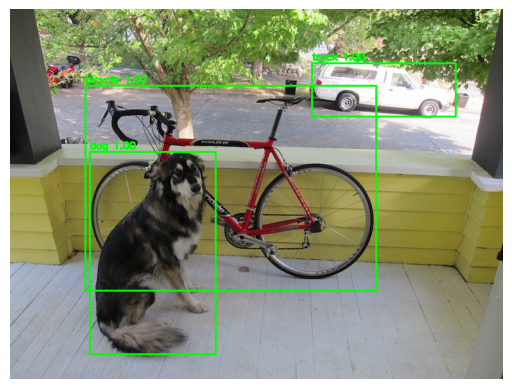

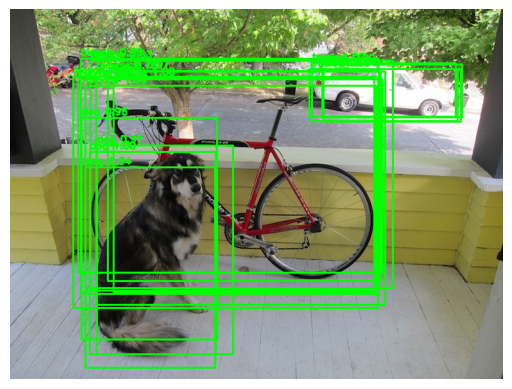

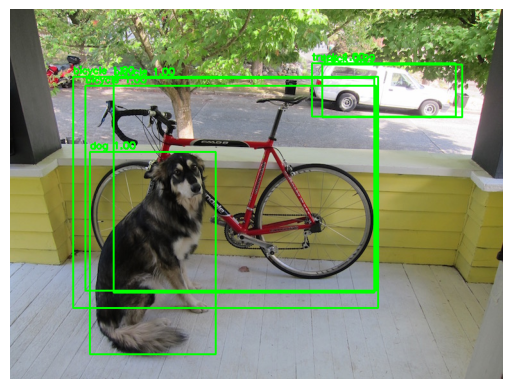

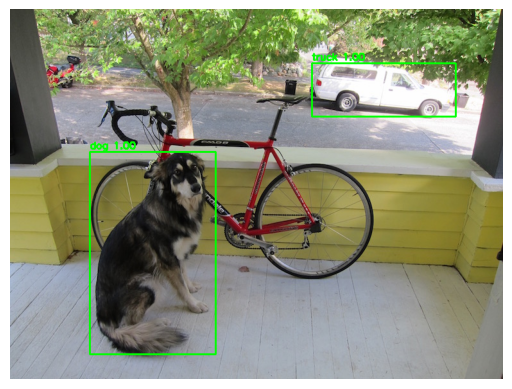

In [17]:
# dog.jpg
detect_draw_detections('images/dog.jpg', 0.5, 0.5)
detect_draw_detections('images/dog.jpg', 0.5, 0.9)
detect_draw_detections('images/dog.jpg', 0.98, 0.9)
detect_draw_detections('images/dog.jpg', 0.9, 0.2)

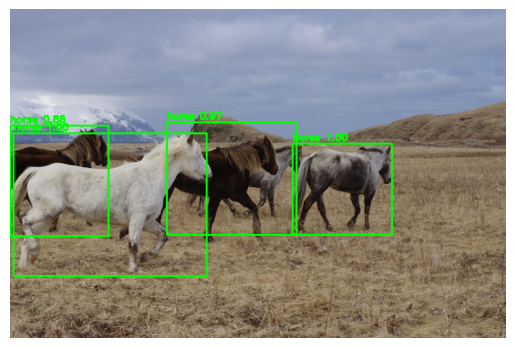

In [18]:
# horses.jpg
detect_draw_detections('images/horses.jpg', 0.5, 0.5)

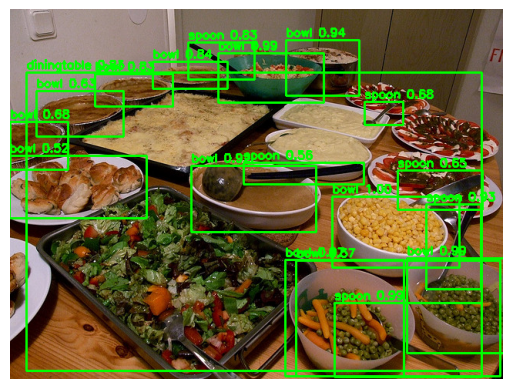

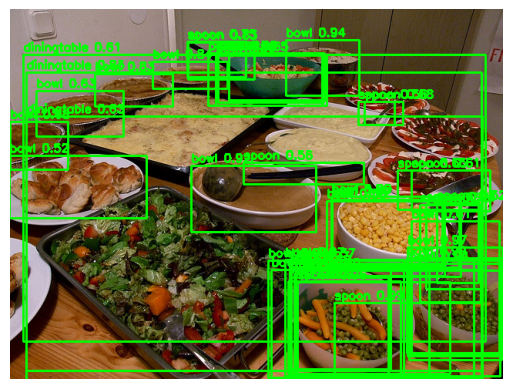

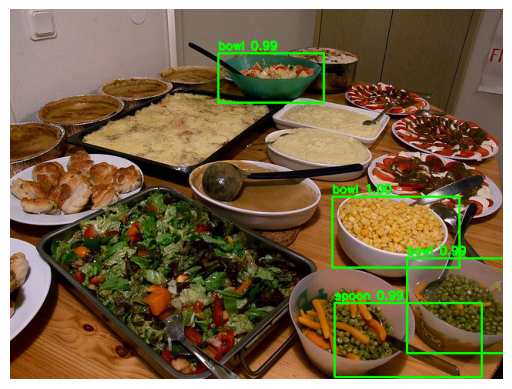

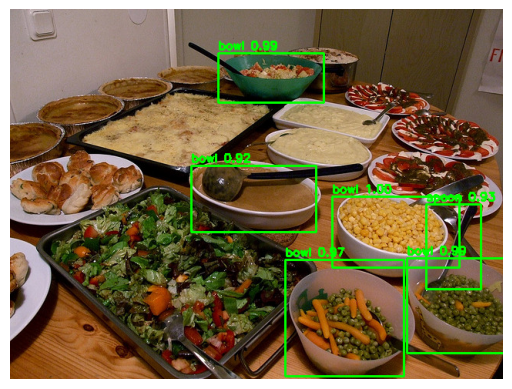

In [19]:
# food.jpg
detect_draw_detections('images/food.jpg', 0.5, 0.5)
detect_draw_detections('images/food.jpg', 0.5, 0.9)
detect_draw_detections('images/food.jpg', 0.98, 0.9)
detect_draw_detections('images/food.jpg', 0.9, 0.2)

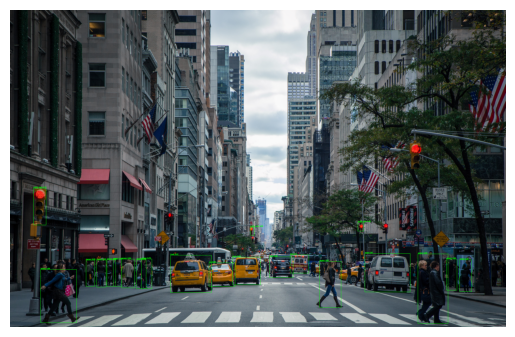

In [20]:
# city_scene.jpg
detect_draw_detections('images/city_scene.jpg', 0.5, 0.5)

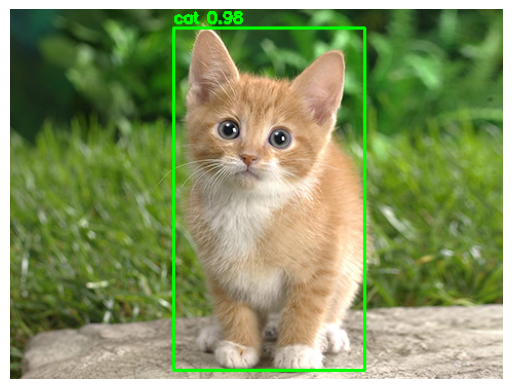

In [21]:
# cat.jpg
detect_draw_detections('images/cat.jpg', 0.5, 0.5)

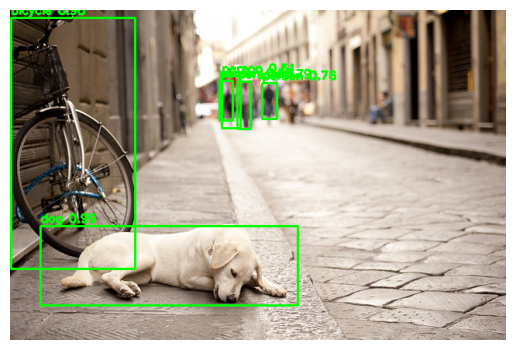

In [22]:
# dog2.jpg
detect_draw_detections('images/dog2.jpg', 0.5, 0.5)

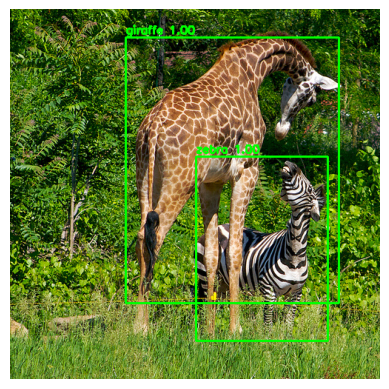

In [23]:
# giraffe.jpg
detect_draw_detections('images/giraffe.jpg', 0.5, 0.5)

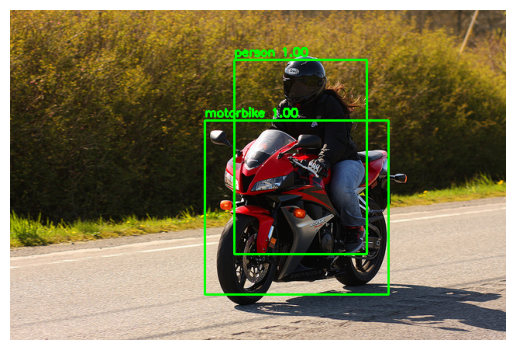

In [24]:
# motorbike.jpg
detect_draw_detections('images/motorbike.jpg', 0.5, 0.5)

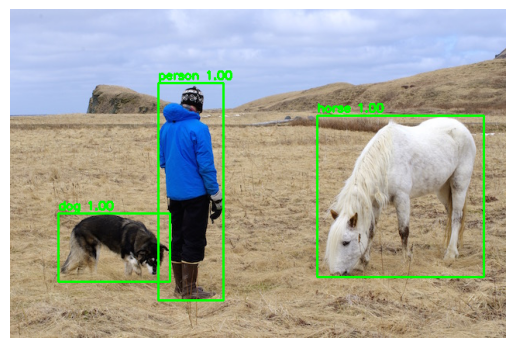

In [25]:
# person.jpg
detect_draw_detections('images/person.jpg', 0.5, 0.5)

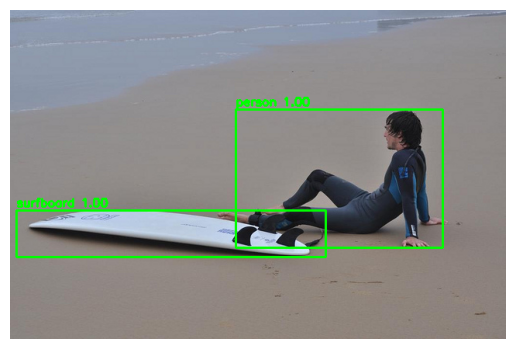

In [26]:
# surf.jpg
detect_draw_detections('images/surf.jpg', 0.5, 0.5)

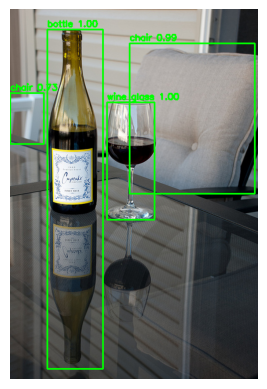

In [27]:
# wine.jpg
detect_draw_detections('images/wine.jpg', 0.5, 0.5)

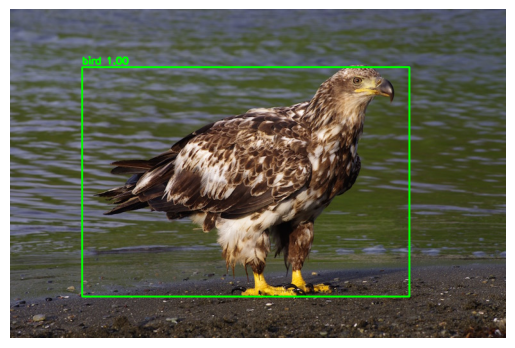

In [28]:
# eagle.jpg
detect_draw_detections('images/eagle.jpg', 0.5, 0.5)